# User EDA – Univariate & Multivariate
Goal: Analyze user-level attributes and how they relate to fraud behavior

In [24]:
from pathlib import Path

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

from mastercard_challenge.visualization.visualize import dist_visualisation, plot_categorical_distributions

In [29]:
sns.set_style("whitegrid")
plt.rcParams["figure.figsize"] = (12, 6)

DATA_PROCESSED_DIR = Path("../data/processed")
DATA_INTERIM_DIR = Path("../data/interim")

In [3]:
df = pd.read_parquet(DATA_PROCESSED_DIR / "users.parquet")

In [4]:
print("Initial shape:", df.shape)

Initial shape: (20000, 10)


In [5]:
df.dtypes

user_id                         object
age                              int64
sex                             object
education                       object
primary_source_of_income        object
sum_of_monthly_installments    float64
sum_of_monthly_expenses        float64
country                         object
signup_date                     object
risk_score                     float64
dtype: object

In [6]:
df.head()

,user_id,age,sex,education,primary_source_of_income,sum_of_monthly_installments,sum_of_monthly_expenses,country,signup_date,risk_score
0,U00001,56,Other,High School,Employment,477.69,243.18,Finland,2021-04-01,0.571079
1,U00002,36,Female,Bachelor,Business,31.60,737.76,France,2020-07-07,0.705268
2,U00003,70,Other,High School,Student Aid,275.72,1477.50,Finland,2022-08-23,0.429579
3,U00004,38,Other,High School,Savings,288.29,1135.03,Belgium,2022-05-21,0.581384
4,U00005,61,Male,High School,Employment,7.00,892.76,Italy,2022-03-15,0.420227


In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20000 entries, 0 to 19999
Data columns (total 10 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   user_id                      20000 non-null  object 
 1   age                          20000 non-null  int64  
 2   sex                          20000 non-null  object 
 3   education                    16138 non-null  object 
 4   primary_source_of_income     20000 non-null  object 
 5   sum_of_monthly_installments  20000 non-null  float64
 6   sum_of_monthly_expenses      20000 non-null  float64
 7   country                      20000 non-null  object 
 8   signup_date                  20000 non-null  object 
 9   risk_score                   20000 non-null  float64
dtypes: float64(3), int64(1), object(6)
memory usage: 1.5+ MB


In [8]:
# --- 1. Data type cleanup ---
df["signup_date"] = pd.to_datetime(df["signup_date"], errors="coerce")

In [9]:
# --- 2. Explicit missing values ---
missing = df.isna().sum()
print("Explicit missing values:\n", missing[missing > 0])

Explicit missing values:
 education    3862
dtype: int64


### Handling Missing Values – `education`

The `education` column contains approximately **3,862 missing values (~19.3%)**, which is a non-trivial portion of the dataset.

To address this:

> We replace missing values with a separate category `"Missing"`.

#### Justification:
- `education` is a **categorical variable**, and treating missing as a distinct level allows the model to learn if missingness itself carries signal.
- This strategy **preserves all rows**, avoiding unnecessary data loss.
- It is **interpretable** and **model-friendly** (works well with tree-based models and one-hot encoding).
- Imputing based on other variables (e.g., age, income) is theoretically possible, but difficult to justify in synthetic or highly balanced datasets.

This approach ensures robustness and allows downstream models to assess whether lack of education data is correlated with fraud behavior.

In [10]:
df["education"] = df["education"].fillna("Missing")

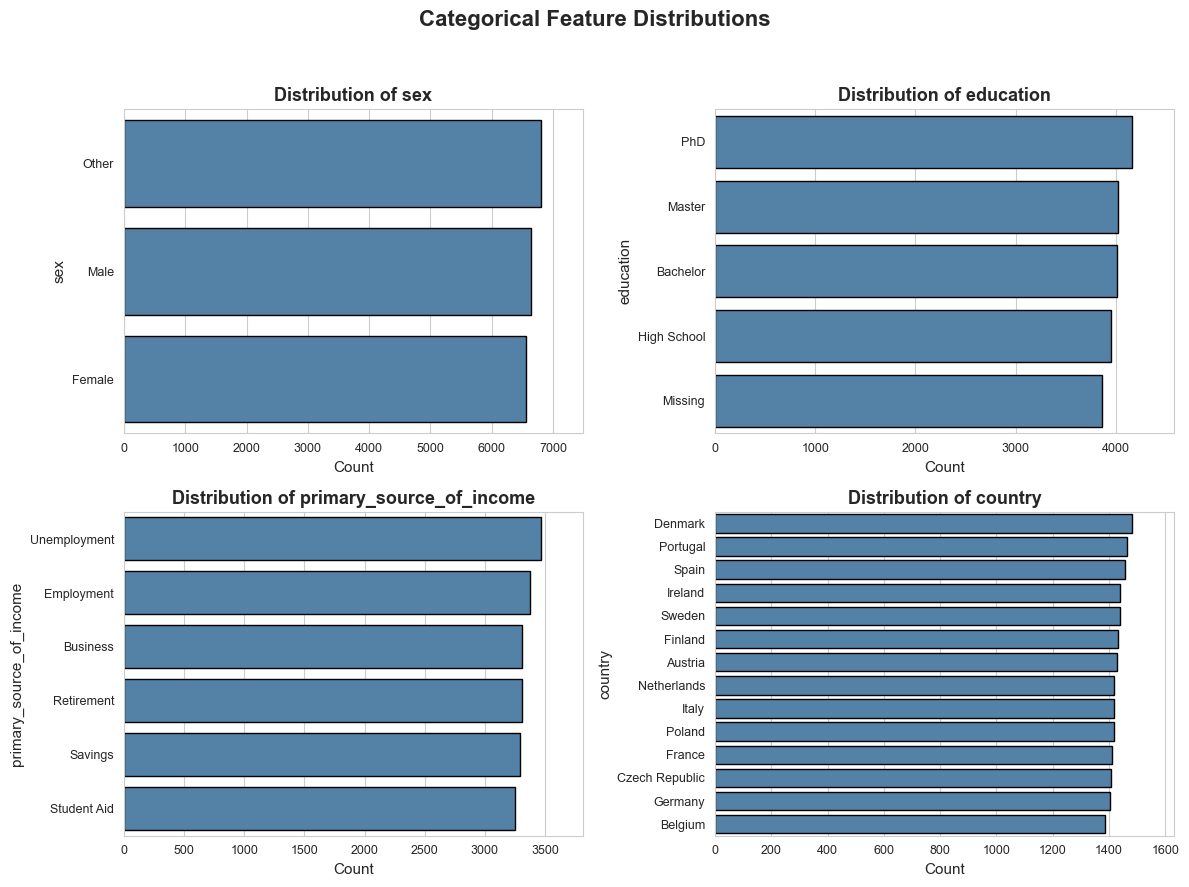

In [11]:
categorical_cols = ["sex", "education", "primary_source_of_income", "country"]
plot_categorical_distributions(df, categorical_cols)

### Updated Categorical Feature Distributions – Observations

#### `sex`
- Still shows a nearly uniform distribution across `Male`, `Female`, and `Other`.
- Confirms that the dataset is synthetically stratified by gender identity.

#### `education`
- The `"Missing"` category now appears clearly in the distribution, with nearly the same count as other levels.
- This indicates that missing values were not random but synthetically distributed to preserve balance.
- Presence of `"Missing"` as a valid category can be informative for downstream models.

#### `primary_source_of_income`
- Continues to show a flat distribution across all 6 categories.
- Reinforces hypothesis that income sources were artificially balanced.

#### `country`
- Uniform distribution across 14 countries, all with roughly equal counts (~1,400).
- Real-world demographic or geographic skew is absent, again pointing to synthetic generation.

### Summary
- After handling missing values in `education`, the distributions remain suspiciously uniform.
- This validates the approach of treating `"Missing"` as a distinct and meaningful category.
- All categorical features appear balanced by design, and may require interaction with other features to be predictive.

### Univariate: numerical

In [17]:
df.dtypes

user_id                                object
age                                     int64
sex                                    object
education                              object
primary_source_of_income               object
sum_of_monthly_installments           float64
sum_of_monthly_expenses               float64
country                                object
signup_date                    datetime64[ns]
risk_score                            float64
dtype: object

In [18]:
numerical_cols = ["age", "sum_of_monthly_installments", "sum_of_monthly_expenses", "risk_score"]

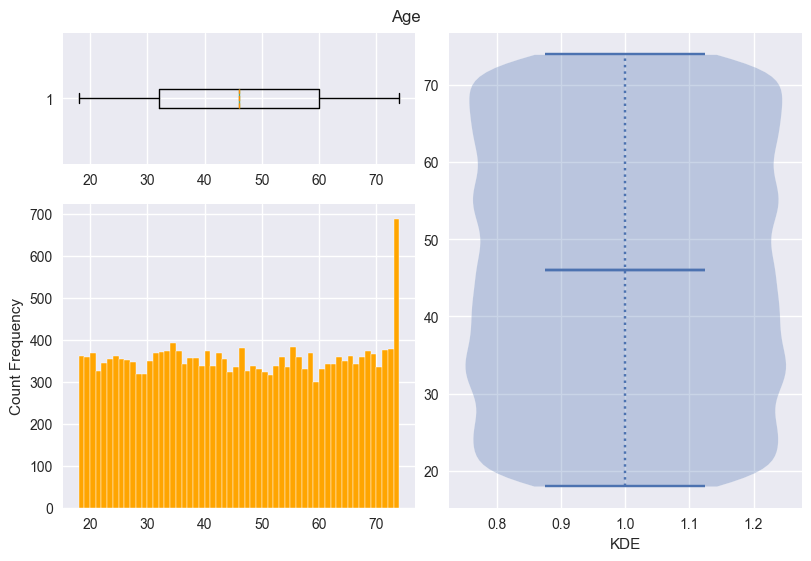

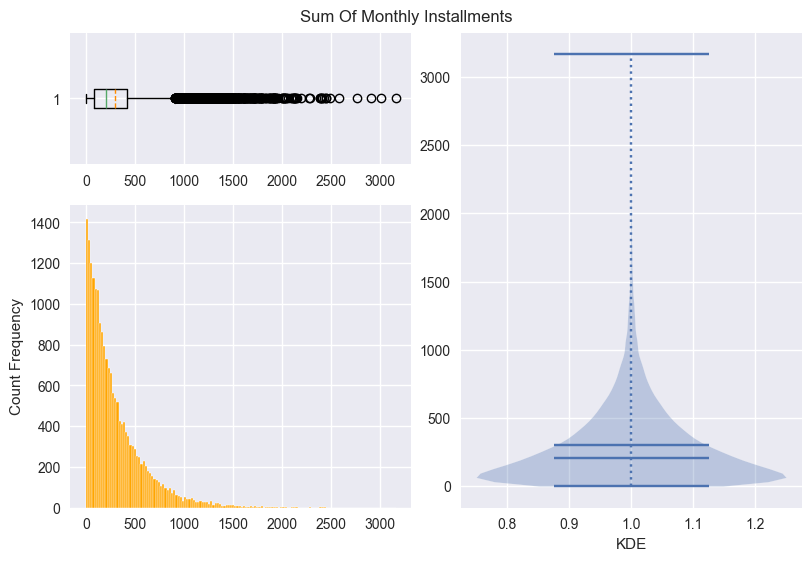

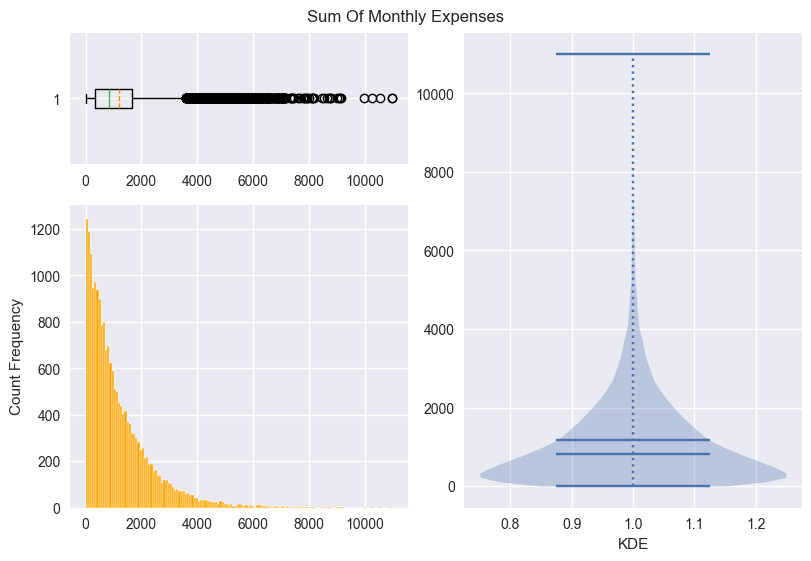

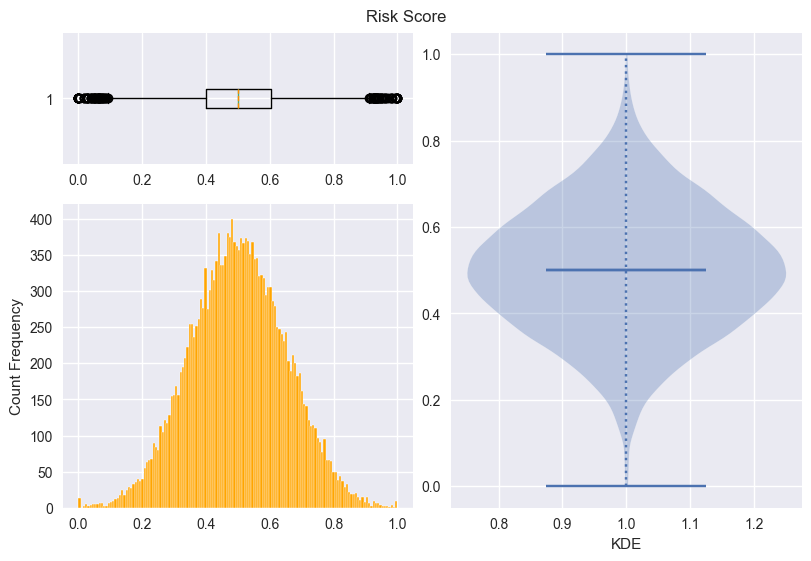

In [21]:
for col in numerical_cols:
    dist_visualisation(df[col], col.title().replace("_", " "))

### Univariate Analysis – Numerical Features

#### 1. `age`
- The distribution is nearly uniform with a strong spike at the upper bound (~75).
- Suggests **synthetic balancing** across all age groups.
- Median age is ~45.
- No outliers or anomalies present.

#### 2. `sum_of_monthly_installments`
- Strongly **right-skewed** distribution.
- Most values lie below 1000, but extreme outliers reach over 3000.
- Heavy tail indicates the need for **log transformation** for modeling.

#### 3. `sum_of_monthly_expenses`
- Also highly **right-skewed**, with a wider range than installments.
- Majority spend below 2000, with some outliers above 10,000.
- Large variance may reduce model stability unless normalized.

#### 4. `risk_score`
- **Bell-shaped, symmetric** distribution centered around 0.5.
- Reflects a likely **synthetic design** to mimic a normal-like risk metric.
- Distribution appears bounded within [0, 1], consistent with a probability score.

### Summary
- Distributions of `installments` and `expenses` suggest the presence of **extreme values** that may require transformation.
- `age` and `risk_score` appear to be **deliberately balanced** to avoid bias.
- Synthetic nature of the data is reinforced by the **clean and uniform spread** of `age` and `risk_score`.

In [25]:
# --- 5. Feature engineering ---
df["account_age_days"] = (pd.Timestamp("2024-01-01") - df["signup_date"]).dt.days

# Apply log transformation to skewed variables
df["log_monthly_installments"] = np.log1p(df["sum_of_monthly_installments"])
df["log_monthly_expenses"] = np.log1p(df["sum_of_monthly_expenses"])


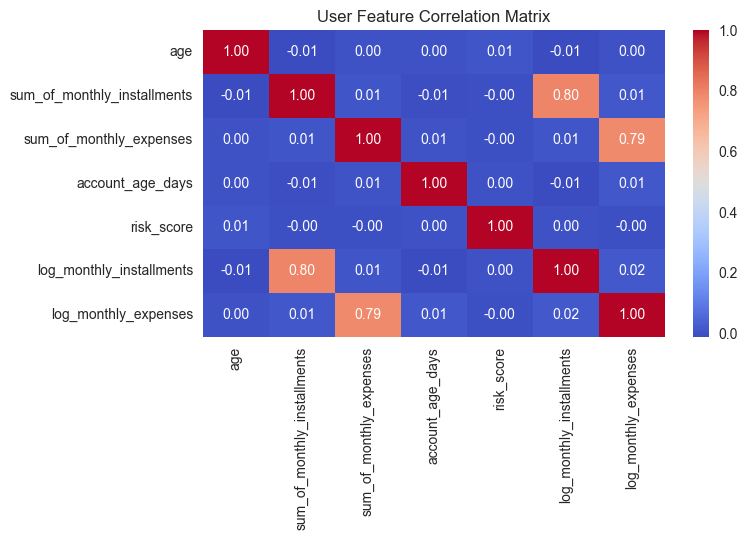

In [27]:
# --- 6. Multivariate: correlation ---
selected = [
    "age", "sum_of_monthly_installments", "sum_of_monthly_expenses",
    "account_age_days", "risk_score", "log_monthly_installments", "log_monthly_expenses"
]
corr = df[selected].corr()
sns.heatmap(corr, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("User Feature Correlation Matrix")
plt.tight_layout()



### User Feature Correlation Matrix – Observations

#### Strong Correlations
- `sum_of_monthly_installments` and `log_monthly_installments`: **ρ ≈ 0.80**
- `sum_of_monthly_expenses` and `log_monthly_expenses`: **ρ ≈ 0.79**

This confirms that the log-transformed features retain most of the original variance while normalizing extreme values.
They can be safely used as input for models that assume normality or penalize skewed distributions.

#### Low or No Correlations
- `risk_score` has **very low correlation** with all other numerical features (ρ < 0.02).
- `account_age_days` also shows **no meaningful correlation** with any variable.
- `age` is uncorrelated with all other features (ρ ≈ 0).

This suggests that:
- Features are **orthogonal by design**, likely due to synthetic generation.
- No strong multicollinearity is present (except within transformed pairs).

#### Recommendation
-  **drop the original versions** (`sum_of_monthly_*`) in favor of their log-transformed counterparts.
- Feature interactions may be more important than raw correlation for downstream modeling.

In [28]:
df = df.drop(columns=[
    "sum_of_monthly_installments",
    "sum_of_monthly_expenses"
])

In [30]:
df.to_parquet(DATA_INTERIM_DIR / "users_log_transformed.parquet", index=False)
